## Observations and Insights 

In [34]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np

plt.style.use('fivethirtyeight')

# Study data files
mouse_metadata_path = "data/Mouse_metadata.csv"
study_results_path = "data/Study_results.csv"

# Read the mouse data and the study results
df_mouse_metadata = pd.read_csv(mouse_metadata_path)
df_study_results = pd.read_csv(study_results_path)

# Combine the data into a single dataset
df_merged = pd.merge(df_mouse_metadata, df_study_results, on='Mouse ID')

# Display the data table for preview
df_merged

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1
...,...,...,...,...,...,...,...,...
1888,z969,Naftisol,Male,9,30,25,63.145652,2
1889,z969,Naftisol,Male,9,30,30,65.841013,3
1890,z969,Naftisol,Male,9,30,35,69.176246,4
1891,z969,Naftisol,Male,9,30,40,70.314904,4


In [35]:
df_merged['Mouse ID'].value_counts()

g989    13
b128    10
t565    10
u327    10
k403    10
        ..
x226     1
n482     1
l872     1
f932     1
b447     1
Name: Mouse ID, Length: 249, dtype: int64

In [36]:
# Getting the duplicate mice by ID number that shows up for Mouse ID and Timepoint. 
duplicate_mice = df_merged[df_merged.duplicated(['Mouse ID', 'Timepoint'])]
duplicate_mice

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
909,g989,Propriva,Female,21,26,0,45.000000,0
911,g989,Propriva,Female,21,26,5,47.570392,0
913,g989,Propriva,Female,21,26,10,49.880528,0
915,g989,Propriva,Female,21,26,15,53.442020,0
917,g989,Propriva,Female,21,26,20,54.657650,1


In [37]:
# Optional: Get all the data for the duplicate mouse ID.
df_merged[df_merged['Mouse ID'] == 'g989']

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
908,g989,Propriva,Female,21,26,0,45.000000,0
909,g989,Propriva,Female,21,26,0,45.000000,0
910,g989,Propriva,Female,21,26,5,48.786801,0
911,g989,Propriva,Female,21,26,5,47.570392,0
912,g989,Propriva,Female,21,26,10,51.745156,0
913,g989,Propriva,Female,21,26,10,49.880528,0
914,g989,Propriva,Female,21,26,15,51.325852,1
915,g989,Propriva,Female,21,26,15,53.442020,0
916,g989,Propriva,Female,21,26,20,55.326122,1
917,g989,Propriva,Female,21,26,20,54.657650,1


In [38]:
# Create a clean DataFrame by dropping the duplicate mouse by its ID.
df_merged = df_merged.set_index('Mouse ID')
mouse = df_merged.drop(index = 'g989')
df_clean = mouse.reset_index()
df_clean

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1
...,...,...,...,...,...,...,...,...
1875,z969,Naftisol,Male,9,30,25,63.145652,2
1876,z969,Naftisol,Male,9,30,30,65.841013,3
1877,z969,Naftisol,Male,9,30,35,69.176246,4
1878,z969,Naftisol,Male,9,30,40,70.314904,4


In [39]:
# Checking the number of mice in the clean DataFrame.
len(df_clean)

1880

## Summary Statistics

In [40]:
df_clean['Drug Regimen'].unique()

array(['Ramicane', 'Capomulin', 'Infubinol', 'Placebo', 'Ceftamin',
       'Stelasyn', 'Zoniferol', 'Ketapril', 'Propriva', 'Naftisol'],
      dtype=object)

In [41]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen

# This method produces everything in a single groupby function
df_tumor_summary = df_clean.groupby('Drug Regimen').agg({'Tumor Volume (mm3)': ['mean', 'median', 'var', 'std', 'sem']})
df_tumor_summary.rename(columns={'mean': "Mean", 'median': "Median", 'var': "Variance", 'std': "Standard Deviation", 'sem': "SEM"})


Tumor Volume (mm3)                                           \
                           Mean     Median   Variance Standard Deviation   
Drug Regimen                                                               
Capomulin             40.675741  41.557809  24.947764           4.994774   
Ceftamin              52.591172  51.776157  39.290177           6.268188   
Infubinol             52.884795  51.820584  43.128684           6.567243   
Ketapril              55.235638  53.698743  68.553577           8.279709   
Naftisol              54.331565  52.509285  66.173479           8.134708   
Placebo               54.033581  52.288934  61.168083           7.821003   
Propriva              52.320930  50.446266  43.852013           6.622085   
Ramicane              40.216745  40.673236  23.486704           4.846308   
Stelasyn              54.233149  52.431737  59.450562           7.710419   
Zoniferol             53.236507  51.818479  48.533355           6.966589   

                        
                   SEM  
Drug Regimen            
Capomulin     0.329346  
Ceftamin      0.469821  
Infubinol     0.492236  
Ketapril      0.603860  
Naftisol      0.596466  
Placebo       0.581331  
Propriva      0.544332  
Ramicane      0.320955  
Stelasyn      0.573111  
Zoniferol     0.516398

## Bar and Pie Charts

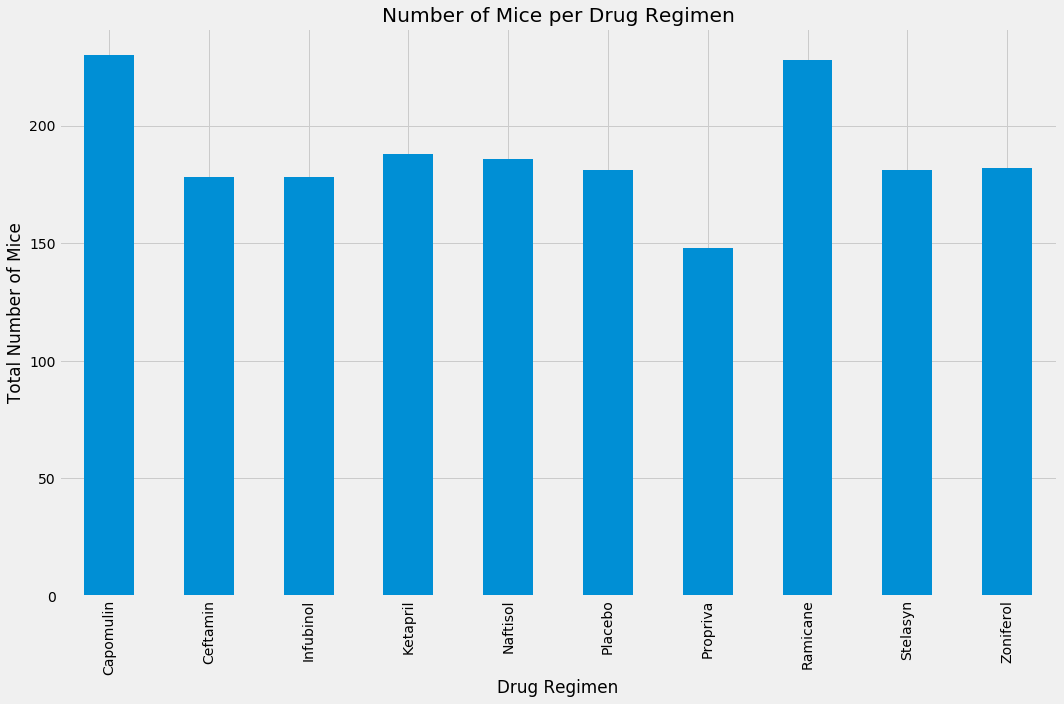

In [42]:
# Generate a bar plot showing the total number of mice for each treatment throughout the course of the study using pandas. 
mice_per_drug = df_clean.groupby(['Drug Regimen']).count()['Mouse ID']

#mice_per_drug_sorted = mice_per_drug.sort_values()

mice_bar = mice_per_drug.plot.bar(figsize=(15,10));
plt.ylabel("Total Number of Mice");
plt.title("Number of Mice per Drug Regimen");
plt.tight_layout()

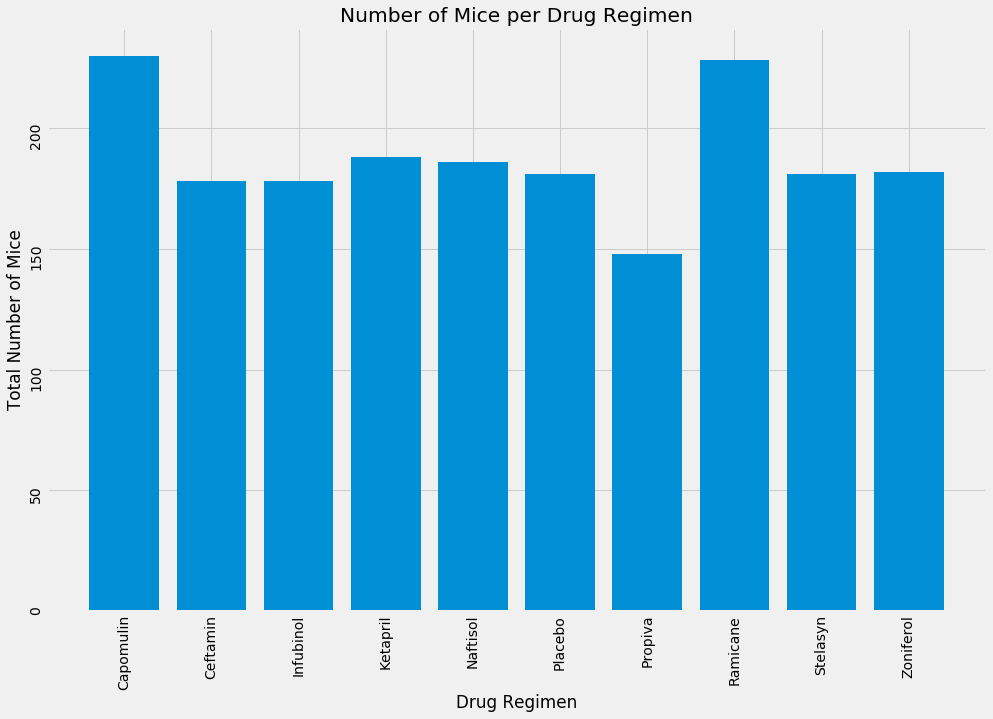

In [43]:
# Generate a bar plot showing the total number of mice for each treatment throughout the course of the study using pyplot.

x_axis_drugs = np.arange(len(mice_per_drug))
mice = df_clean.groupby(['Drug Regimen'])['Mouse ID'].count().tolist()

fig1, ax1=plt.subplots(figsize=(15,10))
ax1.bar(x_axis_drugs, mice, align='center');
ax1.set(xlabel = "Drug Regimen",
        ylabel = "Total Number of Mice",
       title = "Number of Mice per Drug Regimen",
       xticks = list(x_axis_drugs),
       xticklabels = ["Capomulin", "Ceftamin", "Infubinol", "Ketapril", "Naftisol", "Placebo",
                      "Propiva", "Ramicane", "Stelasyn", "Zoniferol"]);
ax1.tick_params(labelrotation=90)

In [44]:
# Create a Dataframe for the gender
df_gender = pd.DataFrame(df_clean['Sex'].value_counts(normalize=True))
df_clean['Sex'].count()

1880

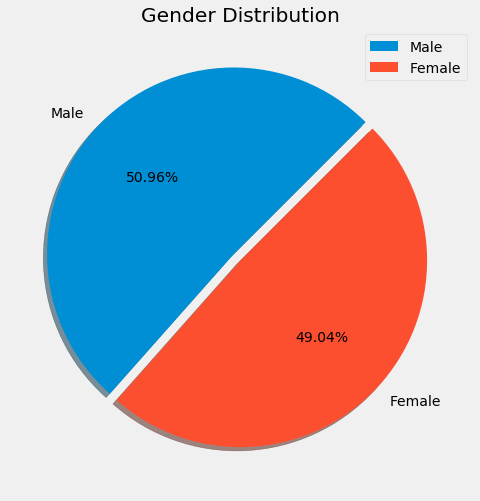

In [45]:
# Generate a pie plot showing the distribution of female versus male mice using pandas

gender_plot = df_gender.plot.pie(y='Sex', figsize=(8,8), autopct='%1.2f%%',
                                explode = (0.05,0), shadow = True,
                                startangle = 45, title="Gender Distribution");
plt.ylabel('');

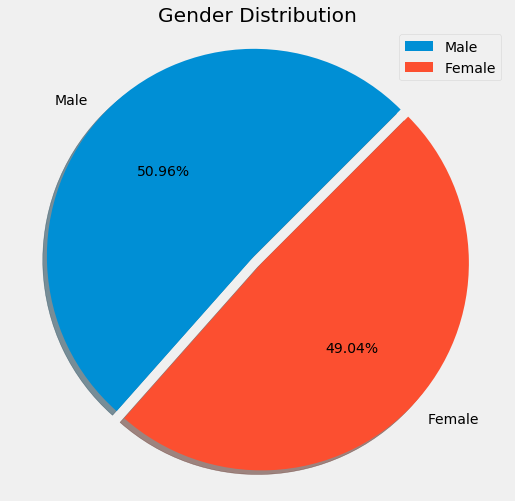

In [46]:
# Generate a pie plot showing the distribution of female versus male mice using pyplot
gender_grp = df_clean.groupby('Sex')

gender_size = [958, 922]
pie_labels = "Male", "Female"

fig2, ax2 = plt.subplots(figsize=(8,8))
ax2.pie(gender_size, labels=pie_labels, autopct='%1.2f%%', startangle=45, shadow=True,
       explode=(0.05,0))
ax2.set_title("Gender Distribution")
ax2.axis("equal")
ax2.legend(loc='upper right');

## Quartiles, Outliers and Boxplots

In [101]:
# Calculate the final tumor volume of each mouse across four of the treatment regimens:  
# Capomulin, Ramicane, Infubinol, and Ceftamin
df_clean_copy = df_clean.copy()

# Start by getting the last (greatest) timepoint for each mouse
df_top_drugs = df_clean_copy[df_clean_copy['Drug Regimen'].isin(['Capomulin', 'Ramicane', 'Infubinol', 'Ceftamin'])]

timepoint = df_top_drugs.groupby('Mouse ID').max()[['Timepoint', 'Tumor Volume (mm3)']]
df_timepoint = pd.DataFrame(timepoint)
df_timepoint = df_timepoint.rename(columns={'Timepoint': "Final Timepoint", 'Tumor Volume (mm3)':"Final Tumor Volume (mm3)"})

# Merge this group df with the original dataframe to get the tumor volume at the last timepoint
df_tumor= pd.merge(df_timepoint, df_clean_copy, on=('Mouse ID'), how='left')
df_tumor


,Mouse ID,Final Timepoint,Final Tumor Volume (mm3),Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,a203,45,67.973419,Infubinol,Female,20,23,0,45.000000,0
1,a203,45,67.973419,Infubinol,Female,20,23,5,48.508468,0
2,a203,45,67.973419,Infubinol,Female,20,23,10,51.852437,1
3,a203,45,67.973419,Infubinol,Female,20,23,15,52.777870,1
4,a203,45,67.973419,Infubinol,Female,20,23,20,55.173336,1
...,...,...,...,...,...,...,...,...,...,...
809,z581,45,62.754451,Infubinol,Female,24,25,25,54.316407,2
810,z581,45,62.754451,Infubinol,Female,24,25,30,56.286750,2
811,z581,45,62.754451,Infubinol,Female,24,25,35,58.628399,3
812,z581,45,62.754451,Infubinol,Female,24,25,40,60.053740,3


In [15]:
# Put treatments into a list for for loop (and later for plot labels)
tx_list = ['Capomulin', 'Ramicane', 'Infubinol', 'Ceftamin']

# Create empty list to fill with tumor vol data (for plotting)
tumor_vol_data = []

# Calculate the IQR and quantitatively determine if there are any potential outliers. 

    
    # Locate the rows which contain mice on each drug and get the tumor volumes
    
    
    # add subset 
    
    
    # Determine outliers using upper and lower bounds
    

In [16]:
# Generate a box plot of the final tumor volume of each mouse across four regimens of interest


## Line and Scatter Plots

In [17]:
# Generate a line plot of time point versus tumor volume for a mouse treated with Capomulin


In [18]:
# Generate a scatter plot of mouse weight versus average tumor volume for the Capomulin regimen


## Correlation and Regression

In [19]:
# Calculate the correlation coefficient and linear regression model 
# for mouse weight and average tumor volume for the Capomulin regimen
